# Analysis on 2D Heisenberg model

In [1]:
import multiprocessing
import sys
import os
from time import time
from socket import gethostname

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# set plot customisation
plt.rc('font',**{'family':'serif',
             'serif': 'cmr10',
             'size': 12})
plt.rc('mathtext',**{'fontset':'cm'})
plt.rc('axes', unicode_minus=False, linewidth=1.2, xmargin=0,
           prop_cycle=cycler('color', ['#008fd5',
          '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']))

from heisenberg_2d import initialize, metropolis, energy, magnetization

In [2]:
# Settings
snaps = []
n_temp = 200

N = 10
H = 1
steps = 500
temp = np.linspace(1.5, 3.5, n_temp)

## Routine

In [3]:
## small sanity check on input parameters
if N<2 or steps<1 or temp[0]<0:
    print("Invalid command line parameters")

## parameters to calculate running average (notice that these are averages per spin)
n1 = 1.0/(steps*N*N)
n2 = 1.0/(steps*steps*N*N)
   
def start(T: float):
    """ Run the routine for temperature T and return E, M, C, X"""
# for ii, T in enumerate(temp):
    E1=0
    M1=0
    E2=0
    M2=0
    grid = initialize(N) ## get the initial configuration
    beta = 1.0/T ## k_B = 1  


    ## first we equilibrate the system 
    ## (assumption is that snapshots are wanted here)
    for t in range(steps):
        if t in snaps:
            plot_system(grid, t, T, H)

        metropolis(grid, beta, H)

    ## then we start to actually collect data, if we aren't just plotting snapshots
    if len(snaps)==0:
        for t in range(steps):
            metropolis(grid, beta, H)
            tE = energy(grid, H)
            tM = magnetization(grid)

            E1 += tE
            E2 += tE*tE
            M1 += tM
            M2 += tM*tM

        E = n1*E1
        M = n1*M1
        C = beta*beta*(n1*E2 - n2*E1*E1)
        X = beta*(n1*M2 - n2*M1*M1)
        
    return E, M, C, X

In [4]:
# Run the routine in parallel (NB: might not work on windows)
print(f'Using {os.cpu_count()} threads on {gethostname()}')
t0 = time()

with multiprocessing.Pool() as pool:
    results = pool.map(start, temp)
    E, M, C, X = np.array(results).T
    
print(f'wall time: {time() - t0} s')

Using 32 threads on jupyter-savolan2
wall time: 67.39610147476196 s


In [5]:
# gather results in a table just in case
df = pd.DataFrame(results, columns=['E', 'M', 'C', 'X'])
display(df)

,E,M,C,X
0,-0.992486,1.312039,0.078729,0.100951
1,-1.006632,1.334147,0.077526,0.100811
2,-1.000568,1.323419,0.137795,0.158457
3,-1.067748,1.373223,0.038963,0.059936
4,-1.035141,1.353058,0.059162,0.134795
...,...,...,...,...
195,-0.331193,0.536629,0.040534,0.310734
196,-0.340394,0.552711,0.048632,0.419950
197,-0.342936,0.549843,0.059719,0.462526
198,-0.323351,0.531489,0.044352,0.339428


## Plotting

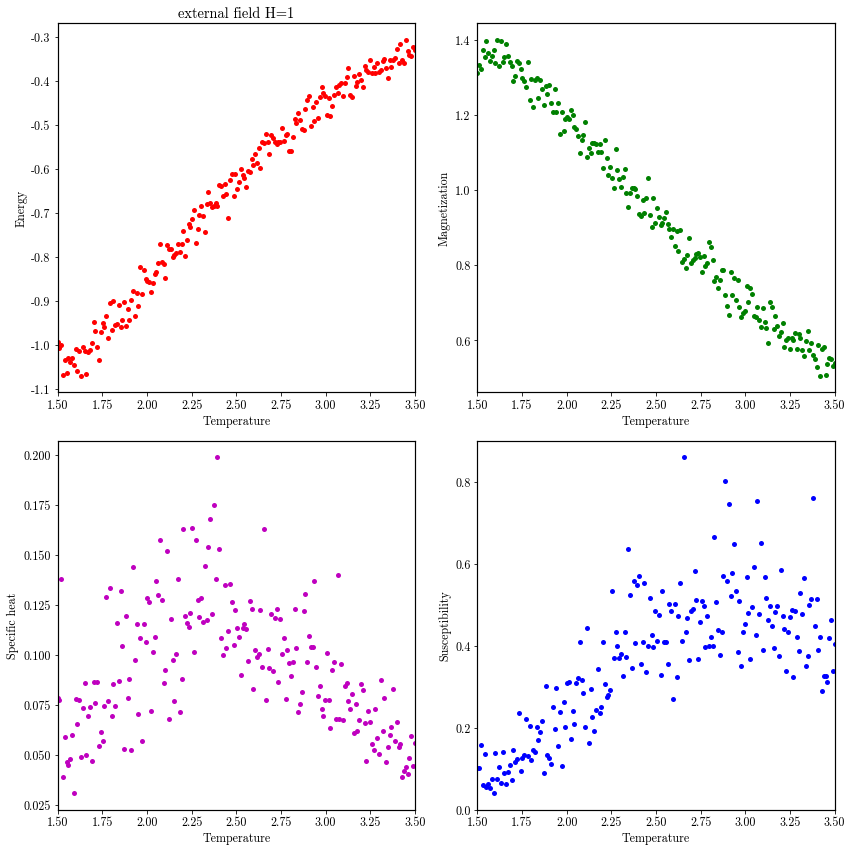

In [6]:
## then we plot a figure with energy, magnetization, specific heat and susceptibility
if len(snaps)==0:
    plt.figure(figsize=(12,12))

    plt.subplot(2,2,1)
    plt.title('external field H={}'.format(H))
    plt.plot(temp, E, 'ro', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Energy')

    plt.subplot(2,2,2)
    plt.plot(temp, M, 'go', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Magnetization')

    plt.subplot(2,2,3)
    plt.plot(temp, C, 'mo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Specific heat')

    plt.subplot(2,2,4)
    plt.plot(temp, X, 'bo', markeredgecolor='none', markersize=5)
    plt.xlabel('Temperature')
    plt.ylabel('Susceptibility')


    plt.tight_layout()
    ## uncomment if you want to save the data
    #np.savetxt("ising_2d_{}_{}_{}.dat".format(N,steps,H), np.array([temp, E, M , C,X]).transpose())

plt.show()
